In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns

from functions.EpiIndex import *

# Important functions

# Reading and preprocessing

In [2]:
raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)
raw.pick_types(eeg=True, bio=False, misc=False)

#Dropping channels
channels = raw.ch_names
channels_to_remove=['E']
raw.drop_channels(channels_to_remove)

#Filter
raw.filter(l_freq = 0, h_freq = 97.0)
# Set the frequency you want to remove; it's commonly 50 Hz or 60 Hz
notch_freq = 60  # or 60 for the USA and other countries using 60Hz
# Apply notch filter
raw.notch_filter(freqs = notch_freq)


Loading FA330022.EEG
Reading header from /home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG
Reading 0 ... 299499  =      0.000 ...   598.998 secs...


/tmp/ipykernel_77920/3372857112.py:1: RuntimeWarning: No PNT file exists. Metadata will be blank
  raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 97 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 97.00 Hz
- Upper transition bandwidth: 24.25 Hz (-6 dB cutoff frequency: 109.12 Hz)
- Filter length: 69 samples (0.138 s)



/tmp/ipykernel_77920/3372857112.py:1: RuntimeWarning: No LOG file exists. Annotations will not be read
  raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,22 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,97.00 Hz


# Getting EI

In [3]:
Ei_n, ER_matrix, U_n_matrix, ER_n_array, alarm_time = get_EI(raw)

In [4]:
Ei_n, ER_matrix, U_n_matrix, ER_n_array, alarm_time = get_EI_optimal_lambda_vs1(raw, np.arange(0,300,50))

Calculating optimal lambda for channel  0
lambda is  0
Total alarm times are  107620
Current best lambda is  0
Current best alarm times are  294501
-------------------
lambda is  50
Total alarm times are  105580
Current best lambda is  0
Current best alarm times are  107620
-------------------
lambda is  100
Total alarm times are  105406
Current best lambda is  50
Current best alarm times are  105580
-------------------
lambda is  150
Total alarm times are  105261
Current best lambda is  100
Current best alarm times are  105406
-------------------
lambda is  200
Total alarm times are  105118
Current best lambda is  150
Current best alarm times are  105261
-------------------
lambda is  250
Total alarm times are  104946
Current best lambda is  200
Current best alarm times are  105118
-------------------
---> Optimal lambda for channel  0  is  250
-------------------
Calculating optimal lambda for channel  1
lambda is  0
Total alarm times are  105788
Current best lambda is  0
Current bes

In [ ]:
Ei_n, ER_matrix, U_n_matrix, ER_n_array, alarm_time, derivates_d1_matrix, derivates_d2_matrix = get_EI_optimal_vs2(raw)

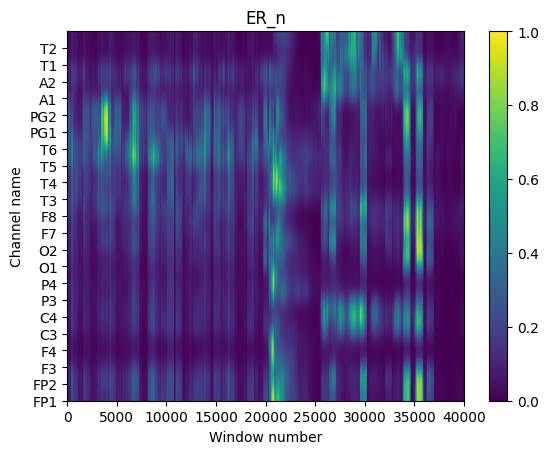

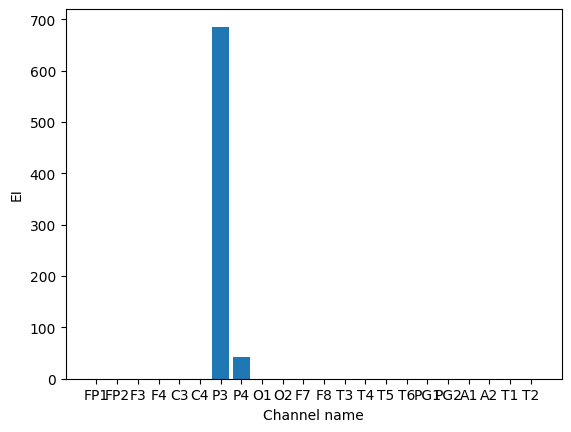

In [4]:
#Making a matrix of U_n, where the rows are every channel and the columns are the windows
#Getting the channels
channels = raw.ch_names
#Getting the number of channels
n_channels=len(channels)
#Getting the number of windows
window_size = 5000#Adjust as needed
overlap = 1 # Adjust as needed
n_windows=len(range(0, len(raw.get_data()[0]) - window_size + 1, overlap))
#Making a matrix of zeros
U_n_matrix=np.zeros((n_channels,n_windows))
ER_matrix=np.zeros((n_channels,n_windows))
ER_n_array=np.zeros(n_channels)
#Alarm time array
alarm_time=np.zeros(n_channels)
#Detection time array
#detection_time=np.zeros(n_channels)
#A loop for every channel
for k in range(n_channels):
    #Getting the data of the channel
    data=raw.get_data()[k]
    #Getting the ER values
    time_points, ER_values = calculate_ER(data, window_size, overlap)
    ER=ER_values
    #Normalizing between 0 and 1
    ER=(ER-np.min(ER))/(np.max(ER)-np.min(ER))
    ER_matrix[k,:]=ER
    N=len(ER)
    ER_n=(1/N)*np.sum(ER)
    #Getting the ER_n values in the 
    ER_n_array[k]=ER_n
    ##Getting U_n
    U_n=np.zeros(len(ER))
    v=0.1
    u_min=0
    #lambda_=108867
    lambda_=125
    alarm_times=[]
    for i in range(N):
        U_n[i]=np.sum(ER[0:i]-ER_n-0.1)
        u_min=np.min(U_n)
        if (U_n[i]-u_min)>lambda_:
            #print('Anomaly detected at window number ',i, ' for channel ',k)    
            alarm_times.append(i)
            u_min=0
            U_n[i]=0
    #Saving the U_n values in the matrix
    U_n_matrix[k,:]=U_n
    #Getting the alarm time
    alarm_time[k]=alarm_times[0]
    
#Getting EI
N0=np.min(alarm_time)
Ei=[]
tau=1
fs=raw.info['sfreq']
#H variable is equal to 5 seconds, so 
H=5*fs
#sum from detection time to the end of the signal
for k in range(n_channels):
    Ei.append(((1/(alarm_time[k]-N0+tau))*np.sum(ER_matrix[k,int(alarm_time[k]):int(alarm_time[k]+H)])))


#Plotting the U_n values for every in a heatmap with an x axis of the window number and a y axis of the channel name with imshow variable "channels" as the labels
plt.imshow(ER_matrix,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
#colorbar
plt.colorbar()
plt.yticks(np.arange(len(channels)), channels)
plt.xlabel('Window number')
plt.ylabel('Channel name')
plt.title('ER_n')
plt.show()

#Plting a barplt of the EI values for every channel
Ei_n=Ei/np.max(Ei)
plt.bar(channels,Ei)
plt.xlabel('Channel name')
plt.ylabel('EI')
plt.show()

# Connectivity Measures

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 50000 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 231 connections
    using t=0.000s..99.998s for estimation (50000 points)
    frequencies: 4.0Hz..9.0Hz (501 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Replacing existin

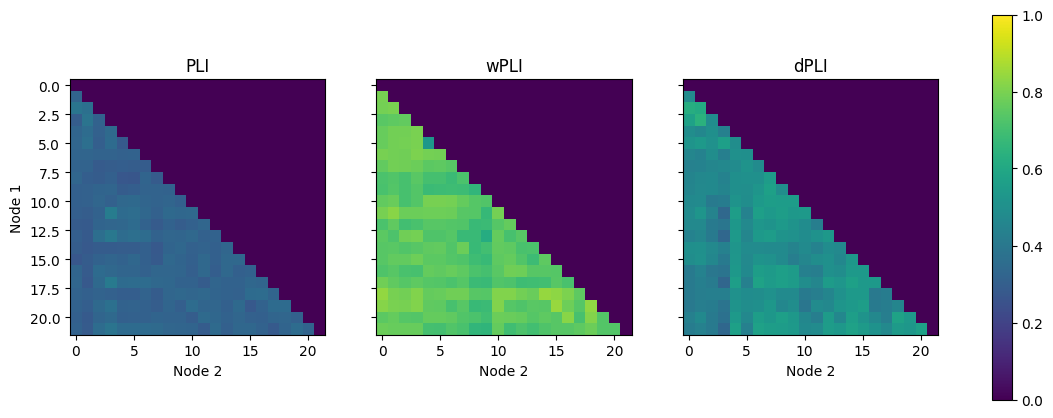

In [5]:
#Making 3 slided windows of 200 seconds with 25% of overlap
epochs = mne.make_fixed_length_epochs(raw, duration=100, overlap=0.25,preload=True)
times=epochs.times
ch_names=epochs.ch_names

fmin, fmax = 4., 9.  # compute connectivity within 4-9 Hz
sfreq = raw.info['sfreq']  # sampling frequency
tmin = 0.0  # exclude the baseline period

# Compute PLI, wPLI, and dPLI
con_pli = spectral_connectivity_epochs(
    epochs, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

con_wpli = spectral_connectivity_epochs(
    epochs, method='wpli', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

con_dpli = spectral_connectivity_epochs(
    epochs, method='dpli', mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)





fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
axs[0].imshow(con_pli.get_data('dense'), vmin=0, vmax=1)
axs[0].set_title("PLI")
axs[0].set_ylabel("Node 1")
axs[0].set_xlabel("Node 2")

axs[1].imshow(con_wpli.get_data('dense'), vmin=0, vmax=1)
axs[1].set_title("wPLI")
axs[1].set_xlabel("Node 2")

im = axs[2].imshow(con_dpli.get_data('dense'), vmin=0, vmax=1)
axs[2].set_title("dPLI")
axs[2].set_xlabel("Node 2")

fig.colorbar(im, ax=axs.ravel())
plt.show()

Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 231 connections
    using t=0.000s..99.998s for estimation (50000 points)
    computing connectivity for the bands:
     band 1: 8.0Hz..13.0Hz (501 points)
     band 2: 13.0Hz..30.0Hz (1701 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Frequencies in Hz over which coherence was averaged for alpha: 
10.5
Frequencies in Hz over which coherence was averaged for be

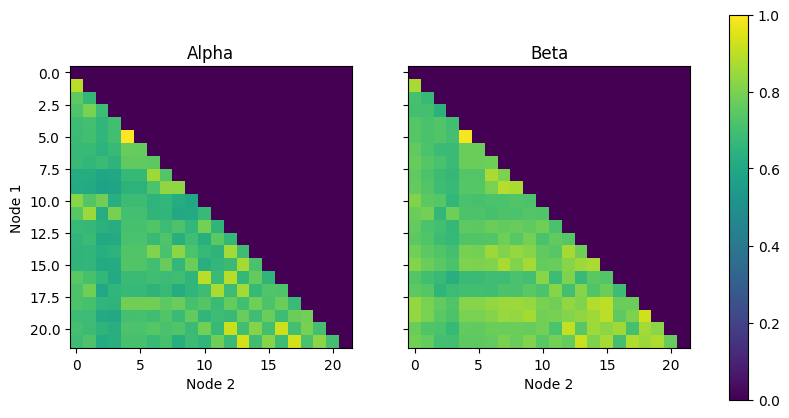

In [6]:
fmin = (8., 13.)
fmax = (13., 30.)
tmin = 0.0 
sfreq = raw.info['sfreq']  # the sampling frequency

coh = spectral_connectivity_epochs(
    epochs, method='coh', mode='fourier', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)
freqs = coh.freqs

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])


#Plotting coherence matrix 
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axs[0].imshow(coh.get_data('dense')[:,:,0], vmin=0, vmax=1)
axs[0].set_title("Alpha")
axs[0].set_ylabel("Node 1")
axs[0].set_xlabel("Node 2")

im = axs[1].imshow(coh.get_data('dense')[:,:,1], vmin=0, vmax=1)
axs[1].set_title("Beta")
axs[1].set_xlabel("Node 2")

fig.colorbar(im, ax=axs.ravel())
plt.show()

# Correlation for graph connection 

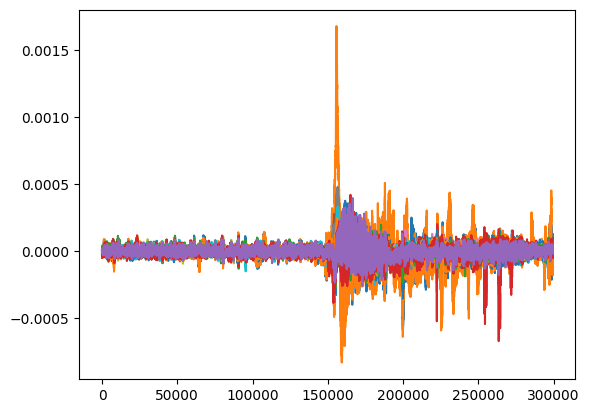

In [7]:
#Saving the data of every channel in a list of lists
chanels=raw.ch_names
data=[]
for i in range(0, len(chanels)):
    data.append(raw.get_data(picks=chanels[i]))

#Plotting the data of every channel in the same plot
for i in range(0, 15):
    plt.plot(data[i][0])
plt.show()

<Axes: >

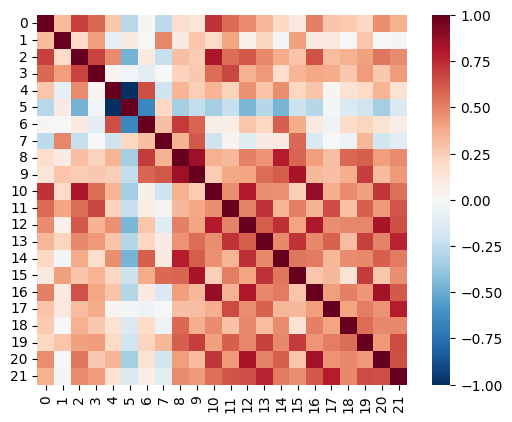

In [8]:
#Measuring connectivity between channels
#Pearson correlation
corr=[]
for i in range(0, len(chanels)):
    for j in range(0, len(chanels)):
        corr.append(np.corrcoef(data[i][0], data[j][0])[0][1])

#Plotting the correlation matrix
corr=np.array(corr)
corr=corr.reshape(len(chanels), len(chanels))
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap='RdBu_r')

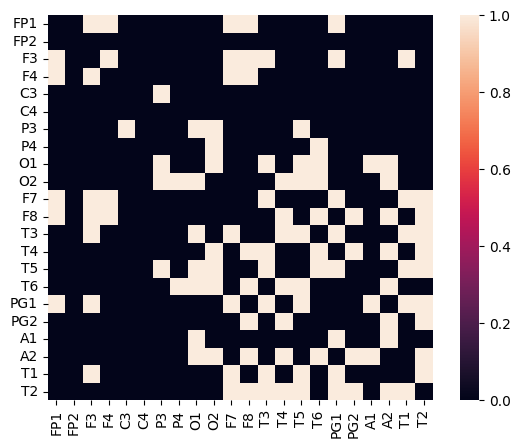

In [9]:
#To create a binary matrix, we use an arbitrary threshold in the correlation 
#matrix
a = Adjacency(corr, matrix_type='similarity', labels=[x for x in chanels])
a_thresholded = a.threshold(upper=.5, binarize=True)

a_thresholded.plot()

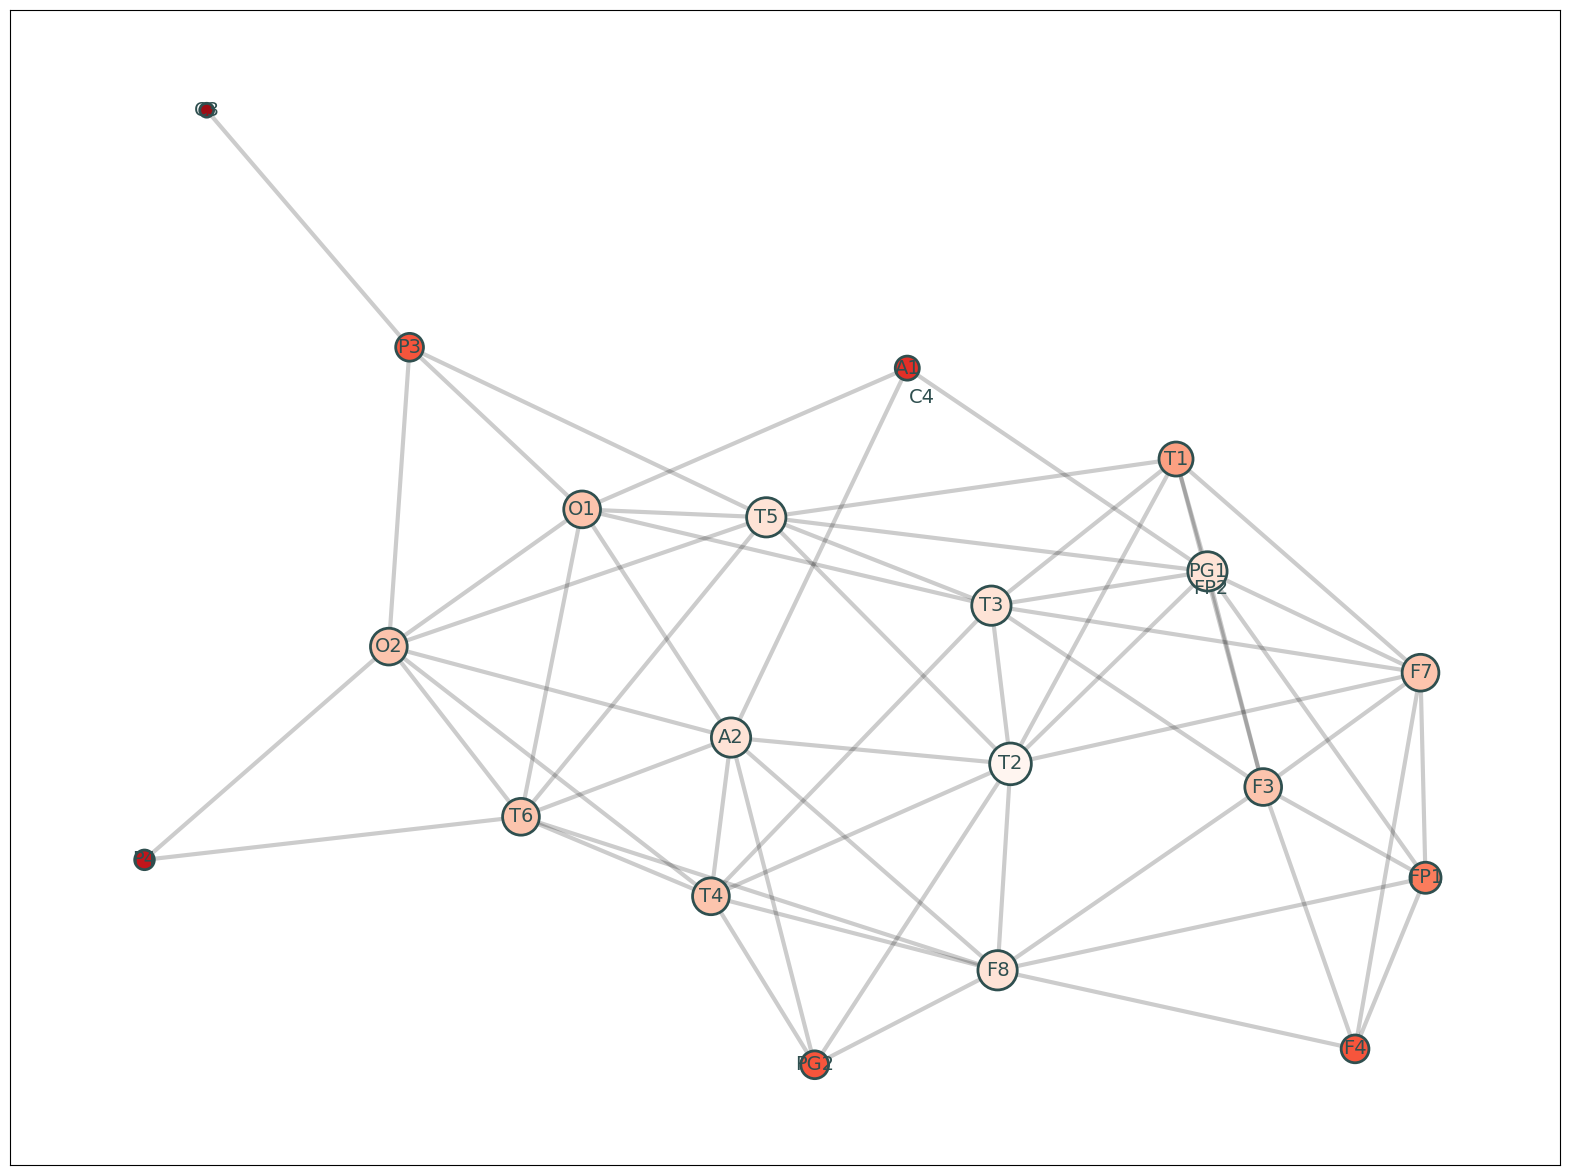

In [10]:
plt.figure(figsize=(20,15))
G = a_thresholded.to_graph()
pos = nx.kamada_kawai_layout(G)
node_and_degree = G.degree()
nx.draw_networkx_edges(G, pos, width=3, alpha=.2)
nx.draw_networkx_labels(G, pos, font_size=14, font_color='darkslategray')

nx.draw_networkx_nodes(G, pos, nodelist=list(dict(node_and_degree).keys()),
                       node_size=[x[1]*100 for x in node_and_degree],
                       node_color=list(dict(node_and_degree).values()),
                       cmap=plt.cm.Reds_r, linewidths=2, edgecolors='darkslategray', alpha=1)


Text(0.5, 0, 'Degree')

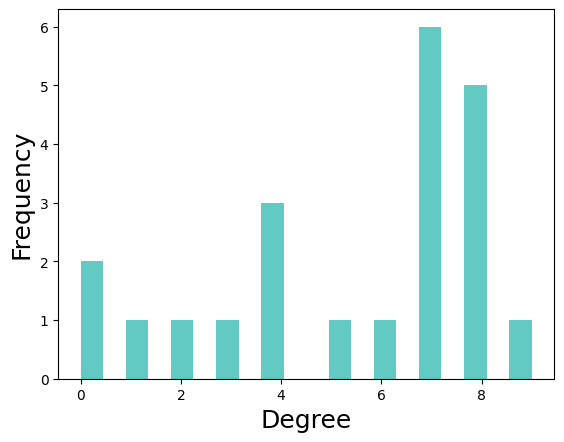

In [11]:
plt.hist(dict(G.degree).values(), bins=20, color='lightseagreen', alpha=0.7)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Degree', fontsize=18)

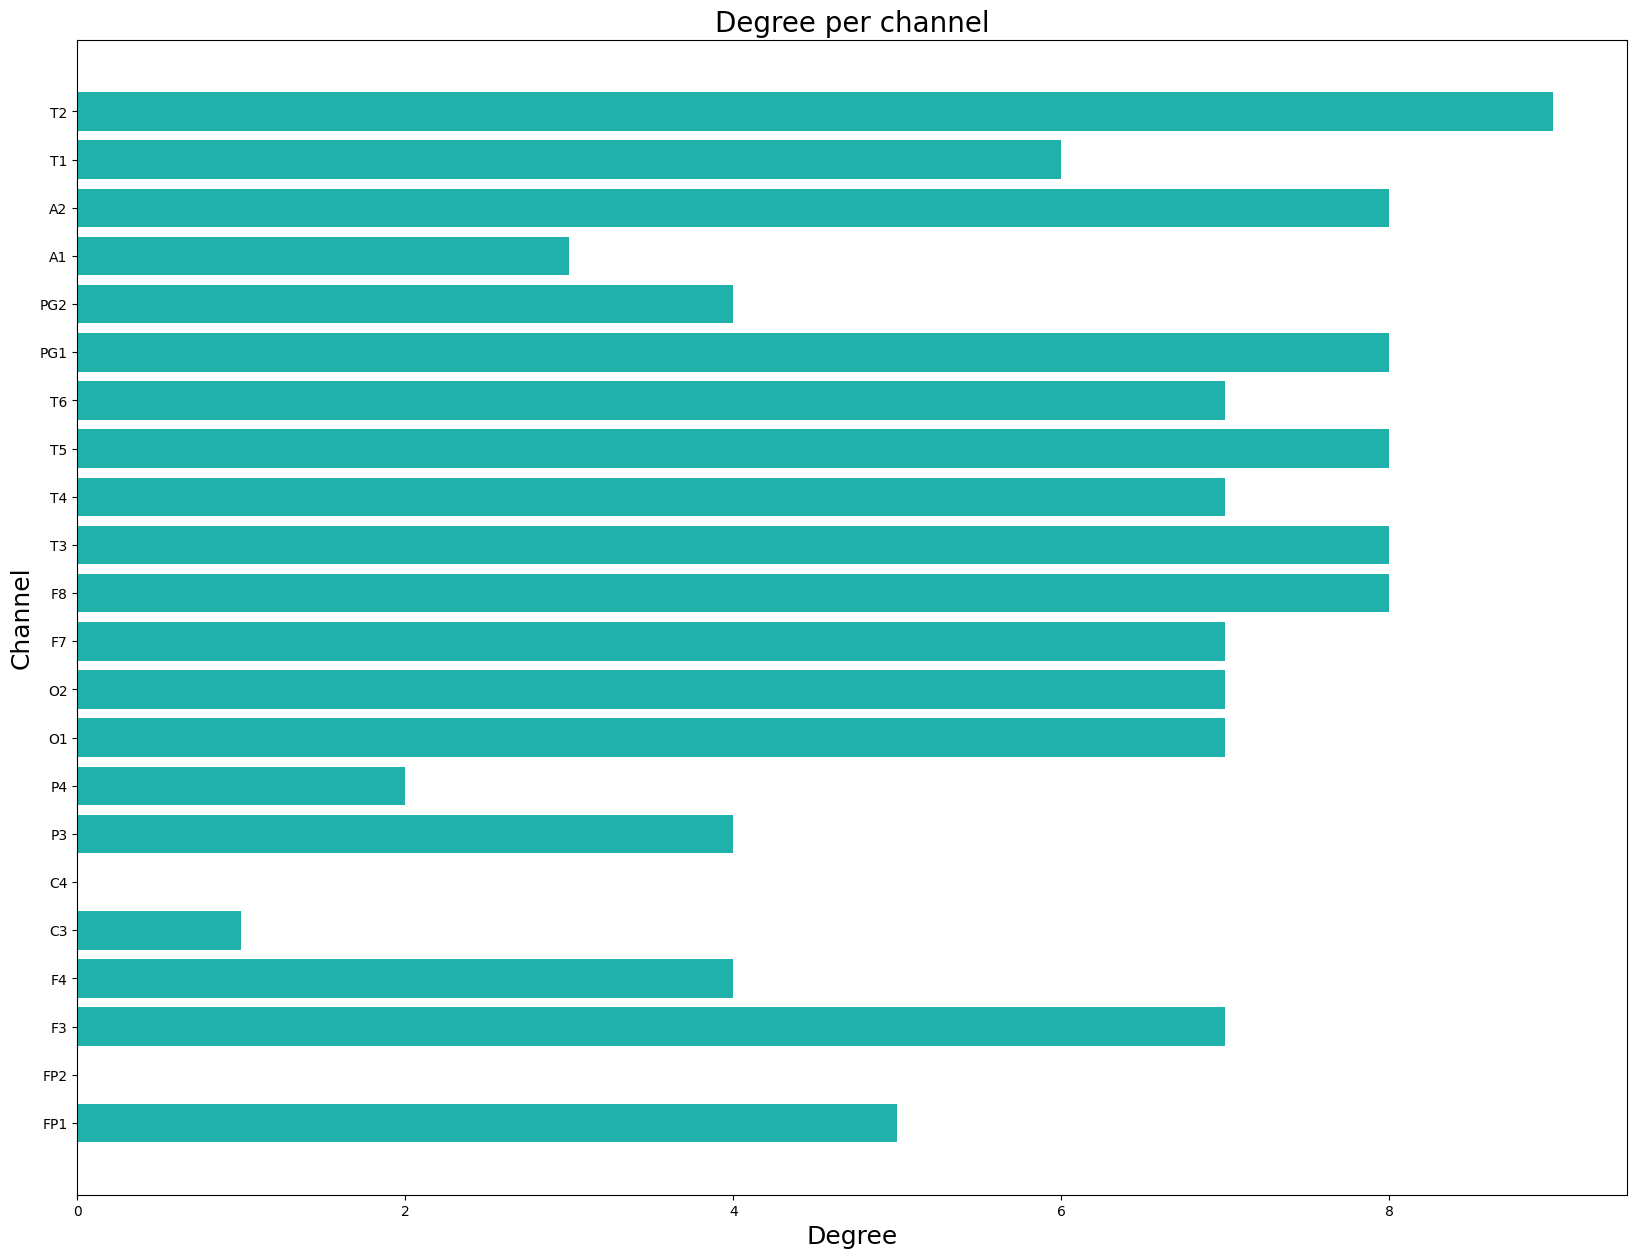

In [12]:
#Degree per channel plot
plt.figure(figsize=(20,15))
plt.barh(list(dict(G.degree).keys()), list(dict(G.degree).values()), color='lightseagreen')
plt.xlabel('Degree', fontsize=18)
plt.ylabel('Channel', fontsize=18)
plt.title('Degree per channel', fontsize=20)
plt.show()